# This notebook analyzes the Zoo sample against galaxies with z < 0.15

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
#from matplotlib_venn import venn3, venn3_circles
import matplotlib.lines as lines
from astropy import constants as const
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table
# import ephem
from astropy.cosmology import FlatLambdaCDM
from scipy import stats as sci

In [3]:
# create datapaths for files and figures
fits_path = '/home/shawn/Desktop/gravitational_lensing_research/FITS_Files/'
csv_path = '/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/'
png_path = '/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/PNGs/'
pdf_path = '/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/Final_PDFs_for_Paper/lambdar_revisions/'

In [6]:
### Samples 02/18/20
#zoo = pd.read_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/zoo_candidates_032020.csv')
#zoo_30 = pd.read_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/zoo_30_021920.csv')
zoo = pd.read_csv(f'{csv_path}zoo_lambdar_revisions_063020.csv')

In [7]:
len(zoo)

13

## Load in Lambdar masses

In [9]:
# Opening GAMA MagPhys data from G09, G12, and G15 (DR3)
hdul = fits.open(f'{fits_path}StellarMassesLambdar.fits')  # open a FITS file
hdul.verify('fix')
lambdar_data = hdul[1].data  # assume the first extension is a table
#print(gama_data.columns)

# take ID and templates/z from first and second fit
GAMA_ID = lambdar_data.CATAID.byteswap().newbyteorder()
lambdar_log_mstar = lambdar_data.logmintsfh.byteswap().newbyteorder()
lambdar_z = lambdar_data.Z.byteswap().newbyteorder()


lambdar_masses = pd.DataFrame(
    {'GAMA_ID' : GAMA_ID,
     'lambdar_log_mstar' : lambdar_log_mstar,
    'z' : lambdar_z}
) 
#     'logmremnants' : logmremnants, 
#     'fluxscale' : fluxscale})
lambdar_masses.GAMA_ID = lambdar_masses.GAMA_ID.astype(int)
lambdar_masses

,GAMA_ID,lambdar_log_mstar,z
0,6802,9.295552,0.05054
1,6806,11.251878,0.33124
2,6808,11.069718,0.22936
3,6810,11.397855,0.32630
4,6813,11.291913,0.48457
...,...,...,...
120614,4341320,10.162766,0.22847
120615,4342359,11.015234,0.64610
120616,4345978,11.303544,0.61111
120617,4347483,11.363264,0.59604


## GalaxyZoo takes galaxies at z < 0.15

In [11]:
gama_zcut = lambdar_masses[lambdar_masses.z < 0.15]
gama_zcut.drop_duplicates(subset = 'GAMA_ID',
                       keep = 'first',
                        inplace = True)
len(gama_zcut)

/home/shawn/miniconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


40903

In [13]:
#gama_zcut.to_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/gama_zoo_cut.csv')

## Plot pg z to log(M*)

Text(0, 0.5, 'Redshift (z)')

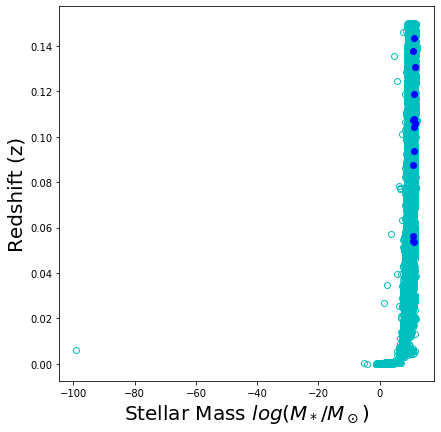

In [14]:
# Three-panel plot
from matplotlib.ticker import NullFormatter
nullfmt   = NullFormatter()         # no labels
# definitions for the axes
left, width = 0.1, 0.65
lower, height = 0.1, 0.65
lower_h = left_h = left+width+0.02
    
rect_scatter = [left, lower, width, height]
#rect_histx = [left, lower_h, width, 0.2]
#rect_histy = [left_h, lower, 0.2, height]
    
    # start with a rectangular Figure
plt.figure(1, figsize=(8,8))
    
axScatter = plt.axes(rect_scatter)
#axHistx = plt.axes(rect_histx)
#axHisty = plt.axes(rect_histy)

binwidth = 0.5
bins=20

    # no labels
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHisty.yaxis.set_major_formatter(nullfmt)

axScatter.plot(gama_zcut.lambdar_log_mstar, gama_zcut.z, 'co', fillstyle = 'none')
axScatter.plot(zoo.lambdar_log_mstar, zoo.z, 'bo')

axScatter.set_xlabel(r'Stellar Mass $log(M_*/M_\odot)$', fontsize=20)
axScatter.set_ylabel(r'Redshift (z)', fontsize=20)

#axHisty.hist(spec.Z, orientation='horizontal', range=[0,0.8], bins=bins,color='b', histtype = 'step', linewidth=3)
#axHisty.hist(pg_sample.Z, orientation='horizontal', range=[0,0.8], bins=bins,color='c', histtype = 'step', linewidth=3)

#axHistx.hist(np.log10(spec.STELLAR_MASS), range=[7,12], bins=bins,color='b', histtype = 'step', linewidth=3)
#axHistx.hist(np.log10(pg_sample.STELLAR_MASS), range=[7,12], bins=bins,color='c', histtype = 'step', linewidth=3)
#plt.savefig('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Visuals/PNGs/spec_gama_pg_zmass.png')

# K-S tests of z and M*

In [15]:
sci.ks_2samp(zoo.z, gama_zcut.z)

Ks_2sampResult(statistic=0.1746928474307884, pvalue=0.8225955046819942)

In [16]:
sci.ks_2samp(zoo.lambdar_mstar, 10**(gama_zcut.lambdar_log_mstar))

Ks_2sampResult(statistic=0.78148302080532, pvalue=2.554047463476346e-07)

# AD tests of z and M*

In [55]:
sci.anderson_ksamp([.Z, pg.Z])

/home/shawn/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: p-value floored: true value smaller than 0.001
  """Entry point for launching an IPython kernel.


Anderson_ksampResult(statistic=177.37253002455355, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)

In [54]:
sci.anderson_ksamp([spec.STELLAR_MASS, pg.STELLAR_MASS])

/home/shawn/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: p-value floored: true value smaller than 0.001
  """Entry point for launching an IPython kernel.


Anderson_ksampResult(statistic=161.47716684141713, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)

## K-S Test of Zoo_30 sample

In [11]:
sci.ks_2samp(zoo_30.Z, gama_zcut.Z)

Ks_2sampResult(statistic=0.12601611640184907, pvalue=0.10659703280856753)

In [12]:
sci.ks_2samp(zoo_30.STELLAR_MASS, gama_zcut.STELLAR_MASS)

Ks_2sampResult(statistic=0.2077424407002299, pvalue=0.0006931516645853038)